In [1]:
from utilities import *
from plot_utilities import *

np.random.seed(42)

In [2]:
# Note that the code below assumes you are in the "testing-framework" directory. Can check Current Working Directory below:
# Should be testing-framework
os.getcwd()

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\testing-framework'

In [3]:
data_dict = pd.read_pickle('../data/Panoptic Agriculture/Transformed Dataset/Panoptic_Data_Dict_Normalized.pickle')
# obs_x_dict = dict()
# for layer in np.arange(2, 9):
#     obs_x_dict[layer] = create_obs_x(data_dict, layer)
# pd.to_pickle(obs_x_dict, 'panoptic/obs_x_dict.pickle')
obs_x_dict = pd.read_pickle('panoptic/obs_x_dict.pickle')
obs_x_dict

{2: array([-99.93568594, -91.00645124, -88.54430615, ...,  88.80035968,
         91.52850405,  94.44944672]),
 3: array([-76.13432886, -63.02074639, -60.52416619, ...,  65.19608846,
         65.26965934,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -45.83266202, ...,  48.25087164,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -43.34915759, -36.2290875 , ...,  36.11999915,
         38.35812055,  42.17747737]),
 6: array([-23.87540781, -23.66829959, -23.29668418, ...,  25.41955052,
         31.52717851,  44.79754701]),
 7: array([-19.12997336, -18.52962064, -17.2224645 , ...,  16.63923718,
         17.96650462,  20.30569957]),
 8: array([-18.71256003, -17.84609759, -16.94317757, ...,  15.43083627,
         16.78232461,  20.5891778 ])}

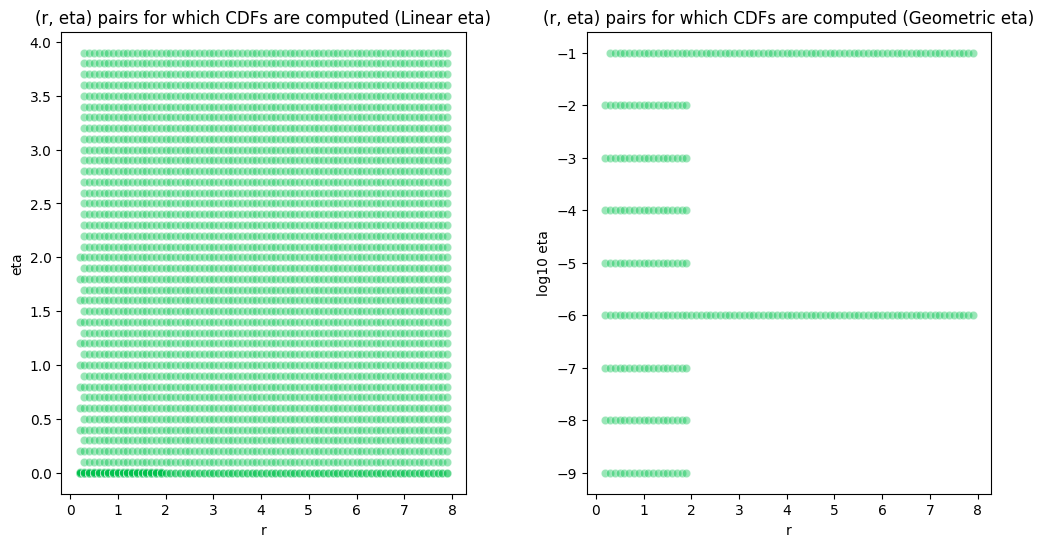

In [4]:
# Large grid search CDFs already computed (r = 0 to 8, eta = 0 to 3.9)
all_cdfs = combine_pickles('scipy_10000') | combine_pickles('mtlb_10000') 
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])

create_scatter_plots_log_eta(all_cdfs_df)

Best parameters (0.6, 3.2) with KS-test Statistic 0.0383 and pvalue 0.0001693037457256742, layer 2 with num_samples=3180


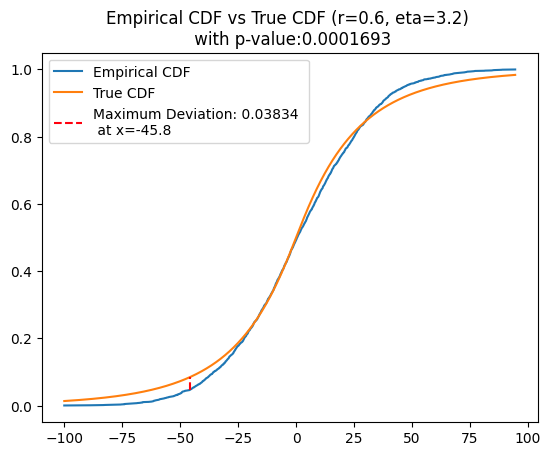

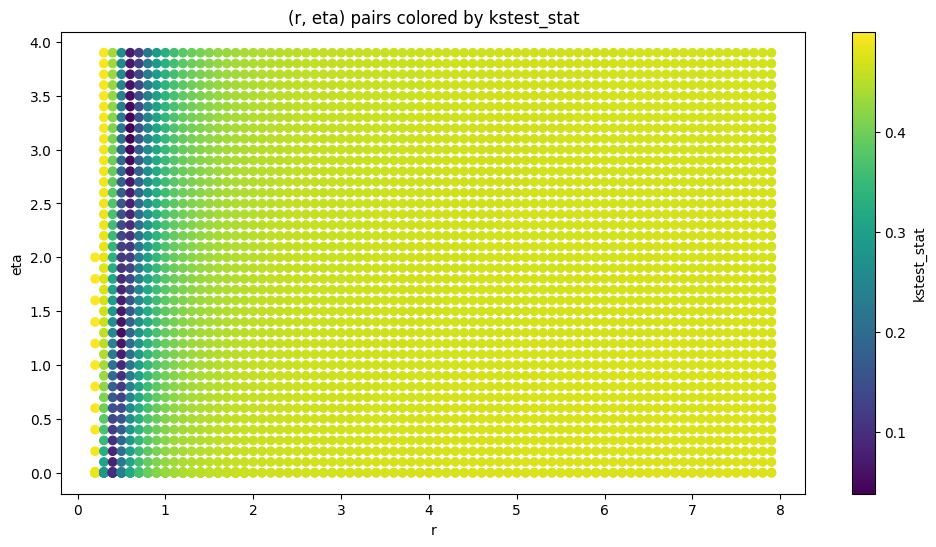

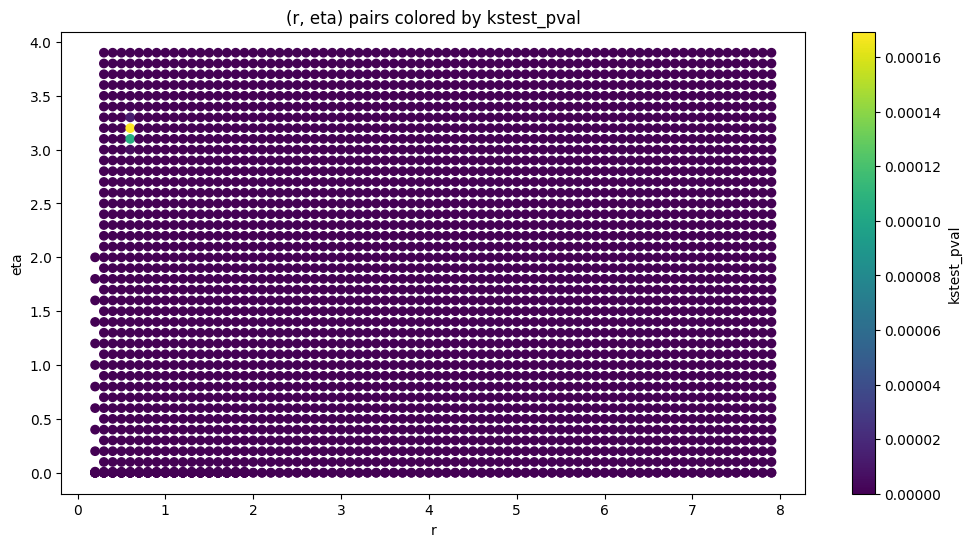

In [5]:
# Experimental cell demoing all the plots
layer = 2
obs_x = obs_x_dict[layer]
all_ksstats, best_param, min_stat = gridsearch(obs_x, all_cdfs)
df = all_cdfs_df.copy()
total_samples = obs_x.size
df['kstest_stat'] = all_ksstats
df['kstest_pval'] = kstwo(n=total_samples).sf(all_ksstats)
print(f"Best parameters {(best_param)} with KS-test Statistic {np.round(min_stat, 4)} and pvalue {kstwo(n=total_samples).sf(min_stat)}, layer {layer} with num_samples={total_samples}")
distance, location = visualize_cdf(obs_x, best_param[0], best_param[1], 10000, all_cdfs)
create_scatter_plot(df, 'kstest_stat')
create_scatter_plot(df, 'kstest_pval')

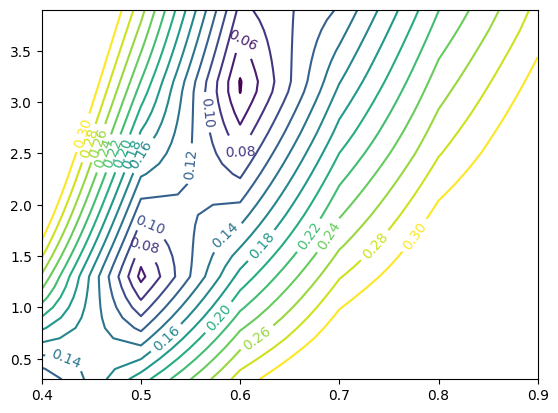

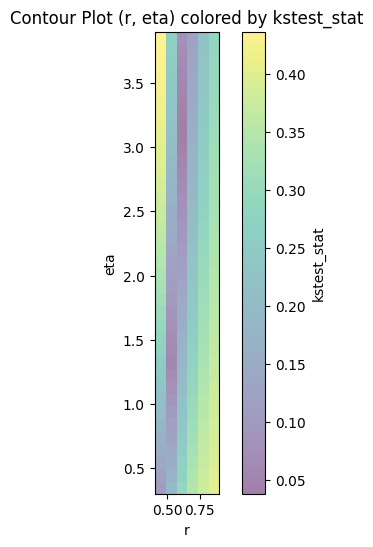

In [6]:
df0 = df[(df['r'] > 0.3) & (df['eta'] >= 0.3) & (df['r'] < 1)]
indices = df0.index
x = np.array(df0['r'].loc[indices])
y = np.array(df0['eta'].loc[indices])
z = np.array(df0['kstest_stat'].loc[indices]) 
X, Y = np.meshgrid(df0['r'].unique(), df0['eta'].unique())

dims_r = df0['r'].unique().size
dims_eta = df0['eta'].unique().size
fig, ax = plt.subplots()
CS = ax.contour(x.reshape(dims_r, dims_eta), y.reshape(dims_r, dims_eta), z.reshape(dims_r, dims_eta), np.append(np.arange(0.04, 0.3, 0.02), 0.3), cmap =  'viridis')
ax.clabel(CS, CS.levels, inline=True, fontsize=10)
create_contour_plot(df0,'kstest_stat')

In [7]:
large_grid_df = pd.DataFrame(columns = ['layer', 'num_samples', 'initial_param', 'kstest_stat', 'best_param_eta_0', 'kstest_stat_eta_0'])
idx_eta_0 = [i for i, param in enumerate(sorted(all_cdfs)) if np.isclose(param[1], 0, atol = 1e-40)]
sorted_params = sorted(all_cdfs)
for i, layer in enumerate(np.arange(2, 9)):
    sample = obs_x_dict[layer]
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs)
    ksstats_eta_0 = [ksstats[i] for i in idx_eta_0]
    idx_min_ksstats_eta_0 = idx_eta_0[np.argmin(ksstats_eta_0)]
    large_grid_df.loc[i, :] = [layer, sample.size, initial_param, min_stat, sorted_params[idx_min_ksstats_eta_0], ksstats[idx_min_ksstats_eta_0]]
large_grid_df = large_grid_df.set_index('layer')
large_grid_df.to_csv(f'panoptic/CSVs/large_grid.csv')
large_grid_df = pd.read_csv(f'panoptic/CSVs/large_grid.csv', index_col='layer')
large_grid_df['initial_param'] = [tuple(float(i) for i in large_grid_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in large_grid_df.index]
large_grid_df

,num_samples,initial_param,kstest_stat,best_param_eta_0,kstest_stat_eta_0
layer,,,,,
2,3180,"(0.6, 3.2)",0.038340,"(0.4, 0)",0.102709
3,12720,"(0.7, 3.5)",0.020230,"(0.4, 0)",0.106739
4,50880,"(0.8, 3.0)",0.011666,"(0.5, 0)",0.061078
5,203520,"(0.9, 1.6)",0.003225,"(0.6, 0)",0.040301
6,814080,"(1.1, 0.5)",0.006844,"(0.9, 0)",0.014370
7,3256320,"(4.6, 0.0)",0.024895,"(4.6, 0)",0.024895
8,13025280,"(5.7, 0.0)",0.171259,"(5.7, 0)",0.171259


In [8]:
# Given that pvalue = 0.05 and I have _ samples, what should the kstest statistic be?

cutoffs_df = pd.DataFrame(columns = ['layer', 'num_samples', 'kstest_stat_0.05_cutoff', 'kstest_stat_0.1_cutoff'])
for i, layer in enumerate(np.arange(2, 9)):
    num_points = obs_x_dict[layer].size
    cutoffs_df.loc[i, :] = (layer, num_points, kstwo(n=num_points).isf(0.05), kstwo(n=num_points).isf(0.1))   
cutoffs_df = cutoffs_df.set_index('layer')
cutoffs_df.to_csv('panoptic/CSVs/cutoffs_df.csv')
cutoffs_df = pd.read_csv('panoptic/CSVs/cutoffs_df.csv', index_col='layer')

In [9]:
large_grid_df['best_r_cd'] = -np.ones(len(large_grid_df))
large_grid_df['best_eta_cd'] = -np.ones(len(large_grid_df))
large_grid_df['kstest_stat_cd'] = -np.ones(len(large_grid_df))

In [10]:
for layer in np.arange(2, 9): 
    sample = obs_x_dict[layer]
    initial_param = large_grid_df.loc[layer, 'initial_param']
    large_grid_df.loc[layer, 'best_r_cd'], large_grid_df.loc[layer, 'best_eta_cd'] = coord_descent_gengamma(sample, initial_param, r_depth = 3, eta_depth=2, layer=layer)
    large_grid_df.loc[layer, 'kstest_stat_cd'] = compute_ksstat(sample, combine_pickles(f'layer{layer}_10000')[(large_grid_df.loc[layer, 'best_r_cd'], large_grid_df.loc[layer, 'best_eta_cd'])])
large_grid_df.to_csv(f'panoptic/CSVs/combined_grid_df.csv')
large_grid_df

CDFs\layer2_10000
CDFs completed: 226
You can find the CDFs here: c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\CDFs\layer2_10000
CDFs\layer2_10000
CDFs completed: 226
(0.591, 3.2), 1 of 21
You can find the CDFs here: c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\CDFs\layer2_10000
CDFs\layer2_10000
CDFs completed: 227
You can find the CDFs here: c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\CDFs\layer2_10000
CDFs\layer3_10000
CDFs completed: 24
(0.6, 3.5), 1 of 20
(0.61, 3.5), 2 of 20
(0.62, 3.5), 3 of 20
(0.63, 3.5), 4 of 20
(0.64, 3.5), 5 of 20
(0.65, 3.5), 6 of 20
(0.66, 3.5), 7 of 20
(0.67, 3.5), 8 of 20
(0.68, 3.5), 9 of 20
(0.69, 3.5), 10 of 20
(0.7, 3.5), 11 of 20
(0.71, 3.5), 12 of 20
(0.72, 3.5), 13 of 20
(0.73, 3.5), 14 of 20
(0.74, 3.5), 15 of 20
(0.75, 3.5), 16 of 20
(0.76, 3.5), 17 of 20
(0.77, 3.5), 18 of 20
(0.78, 3.5), 19 of 20
(0.79, 3.5), 20 of 20
No Tail
You can find

,num_samples,initial_param,kstest_stat,best_param_eta_0,kstest_stat_eta_0,best_r_cd,best_eta_cd,kstest_stat_cd
layer,,,,,,,,
2,3180,"(0.6, 3.2)",0.038340,"(0.4, 0)",0.102709,0.602,3.20,0.036033
3,12720,"(0.7, 3.5)",0.020230,"(0.4, 0)",0.106739,0.705,3.60,0.019860
4,50880,"(0.8, 3.0)",0.011666,"(0.5, 0)",0.061078,0.803,3.00,0.010449
5,203520,"(0.9, 1.6)",0.003225,"(0.6, 0)",0.040301,0.904,1.60,0.004425
6,814080,"(1.1, 0.5)",0.006844,"(0.9, 0)",0.014370,1.030,0.33,0.003707
7,3256320,"(4.6, 0.0)",0.024895,"(4.6, 0)",0.024895,4.630,0.00,0.024879
8,13025280,"(5.7, 0.0)",0.171259,"(5.7, 0)",0.171259,5.700,-0.10,0.163580


In [11]:
large_grid_df['n_0.05'] = large_grid_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_cd'], row.loc['num_samples']), axis = 1)
large_grid_df

,num_samples,initial_param,kstest_stat,best_param_eta_0,kstest_stat_eta_0,best_r_cd,best_eta_cd,kstest_stat_cd,n_0.05
layer,,,,,,,,,
2,3180,"(0.6, 3.2)",0.038340,"(0.4, 0)",0.102709,0.602,3.20,0.036033,1341
3,12720,"(0.7, 3.5)",0.020230,"(0.4, 0)",0.106739,0.705,3.60,0.019860,4770
4,50880,"(0.8, 3.0)",0.011666,"(0.5, 0)",0.061078,0.803,3.00,0.010449,16098
5,203520,"(0.9, 1.6)",0.003225,"(0.6, 0)",0.040301,0.904,1.60,0.004425,96592
6,814080,"(1.1, 0.5)",0.006844,"(0.9, 0)",0.014370,1.030,0.33,0.003707,128142
7,3256320,"(4.6, 0.0)",0.024895,"(4.6, 0)",0.024895,4.630,0.00,0.024879,3016
8,13025280,"(5.7, 0.0)",0.171259,"(5.7, 0)",0.171259,5.700,-0.10,0.163580,67


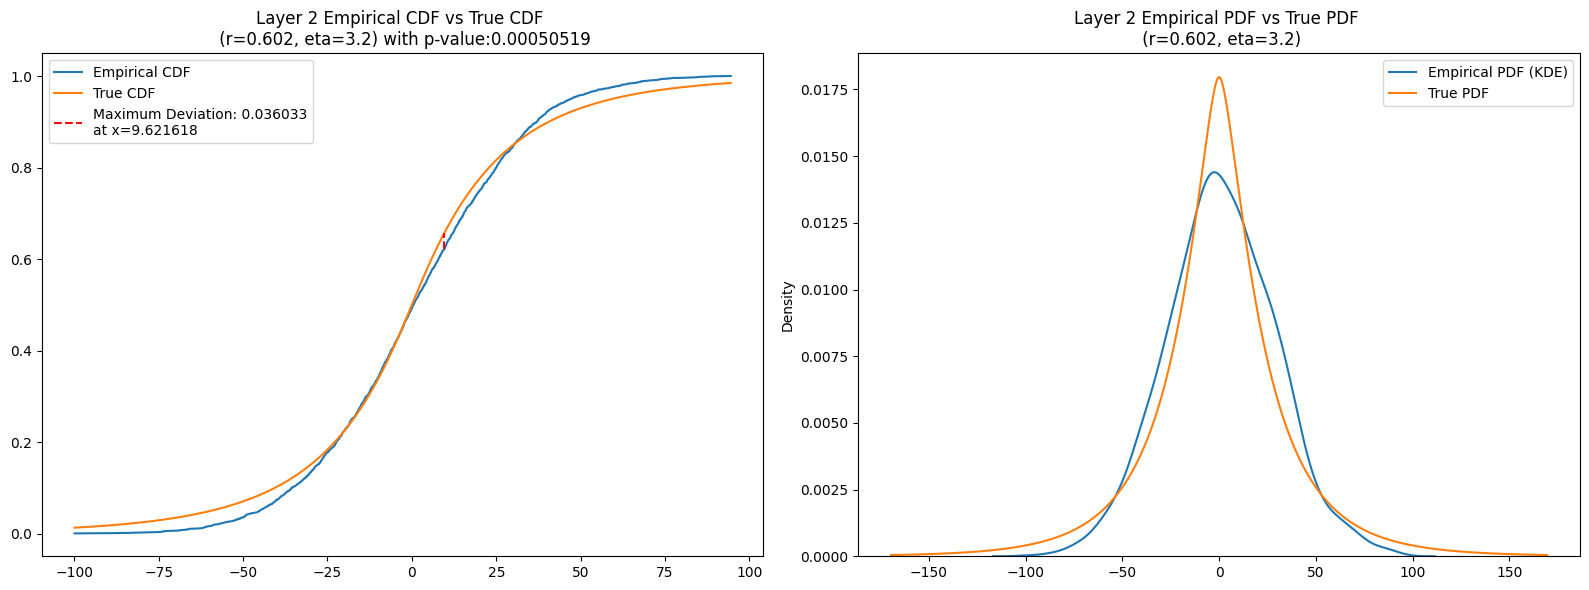

No Tail


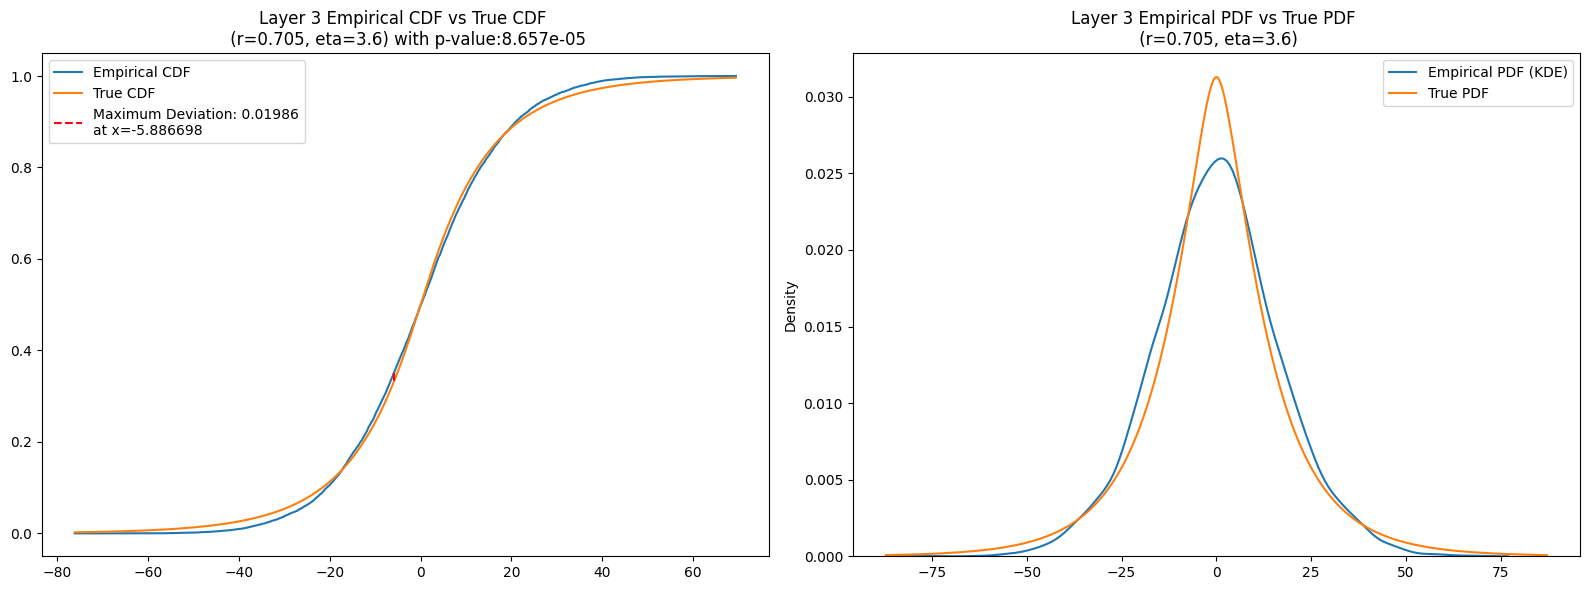

No Tail


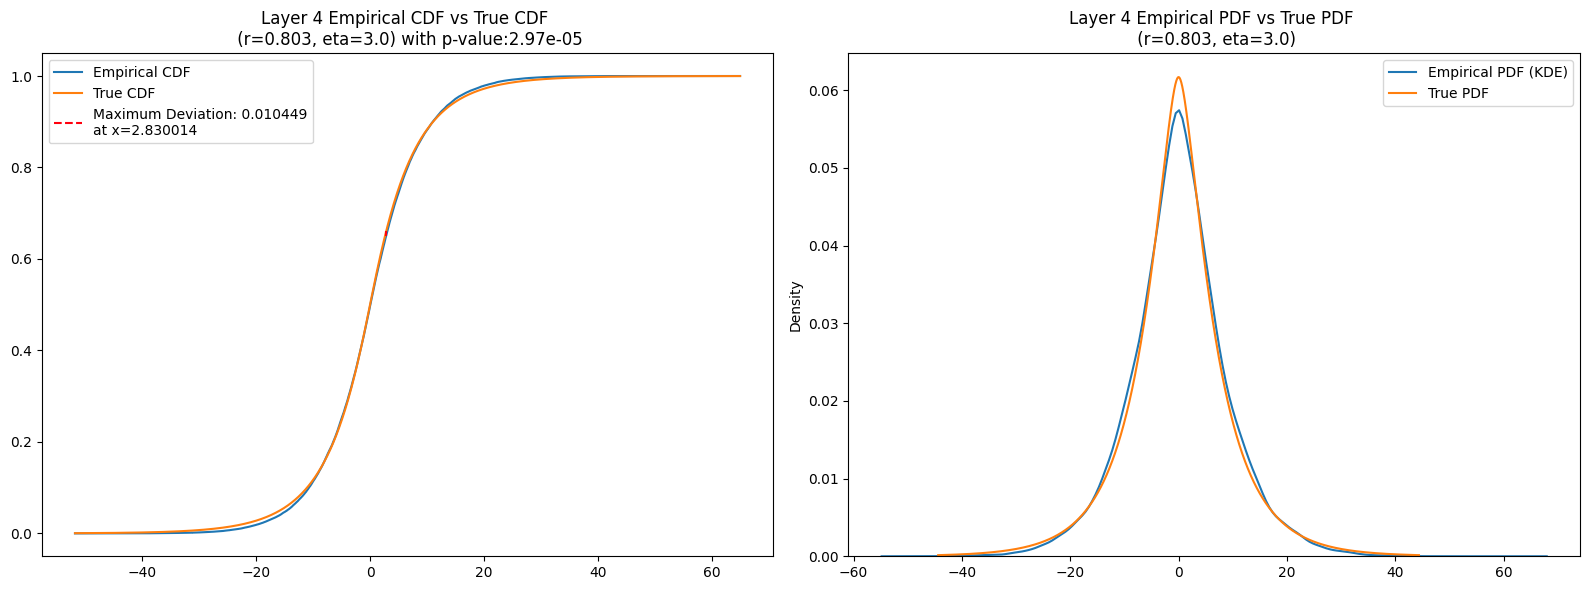

No Tail


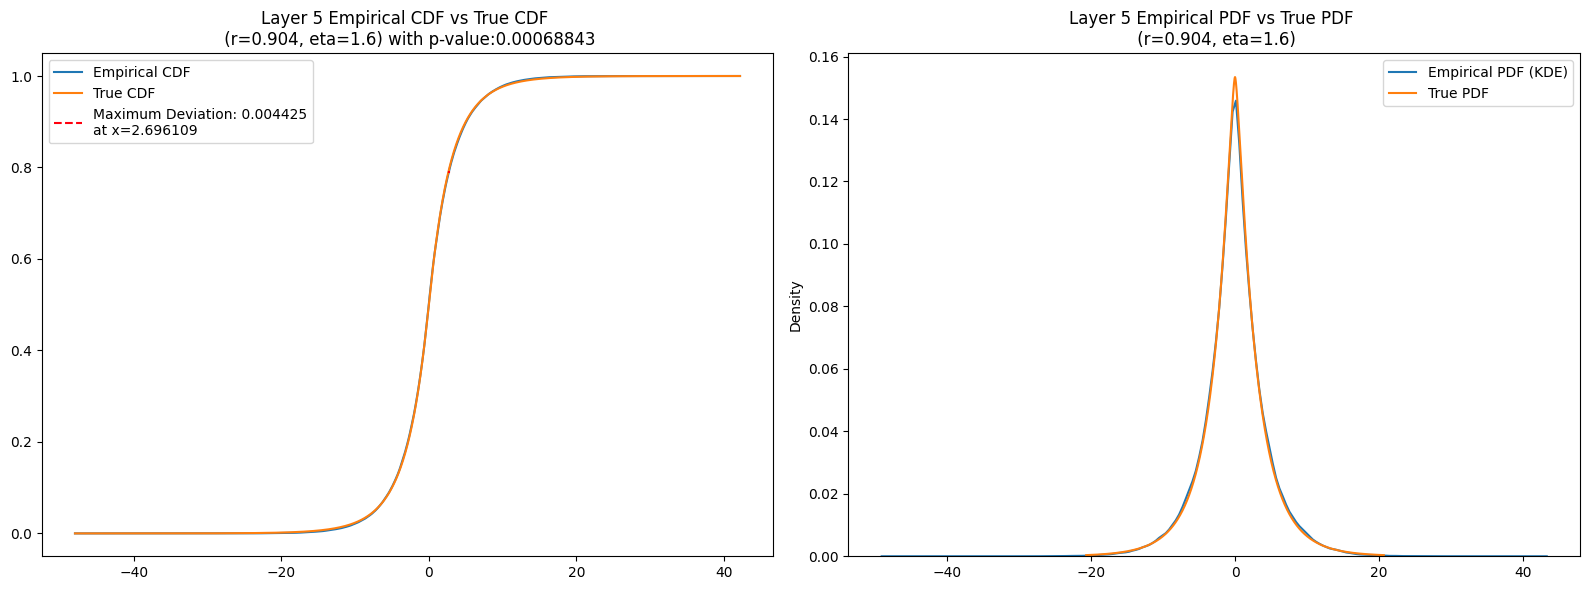

No Tail


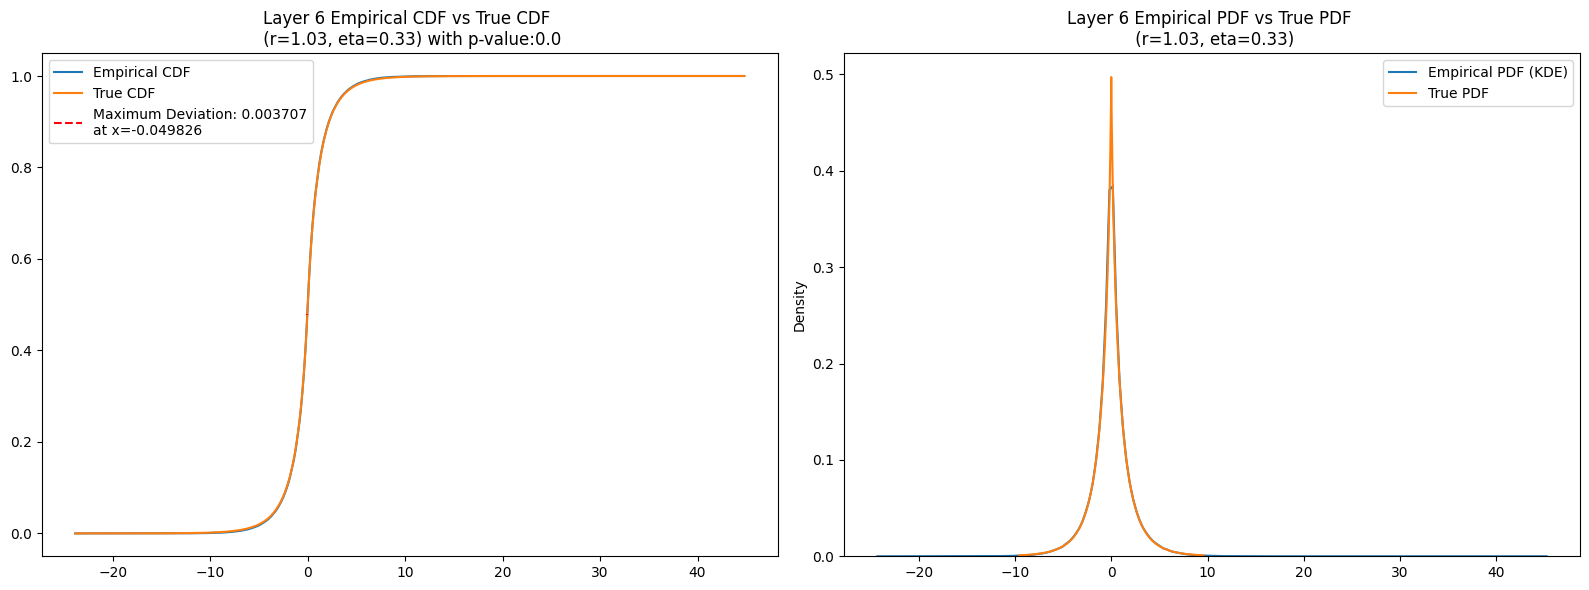

No Tail


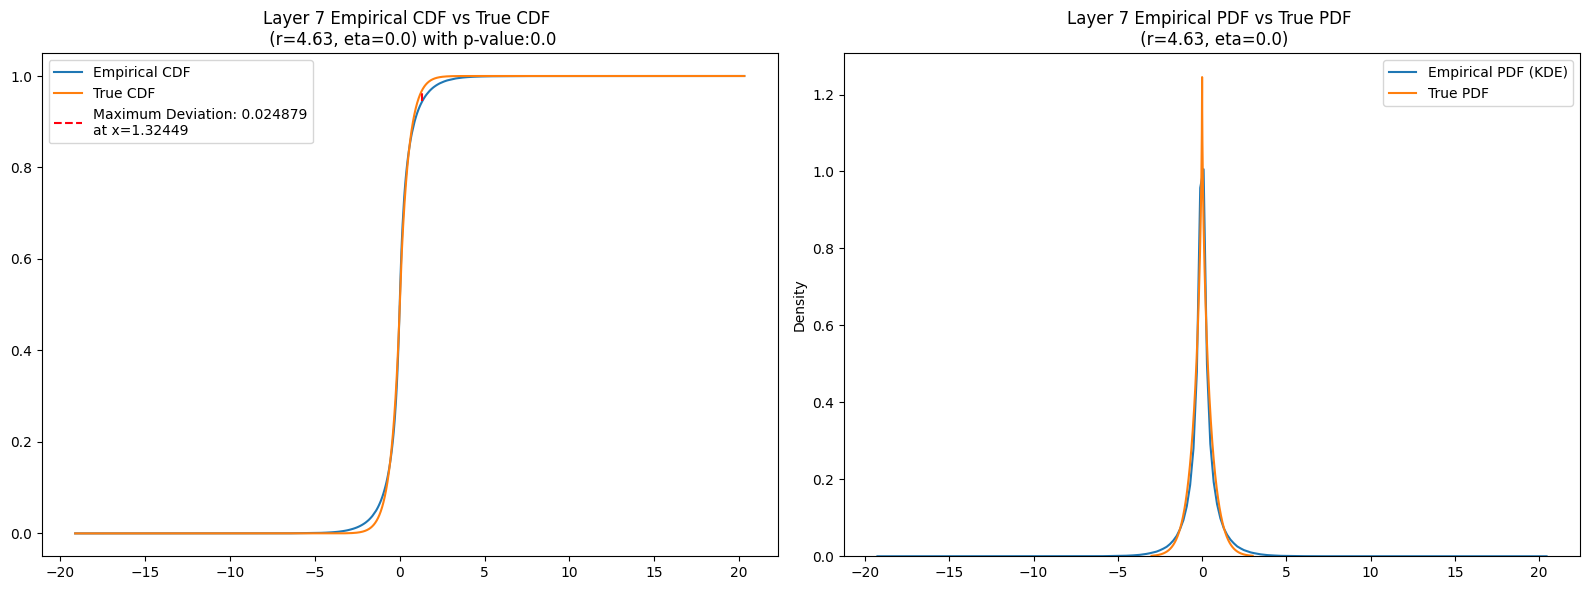

No Tail


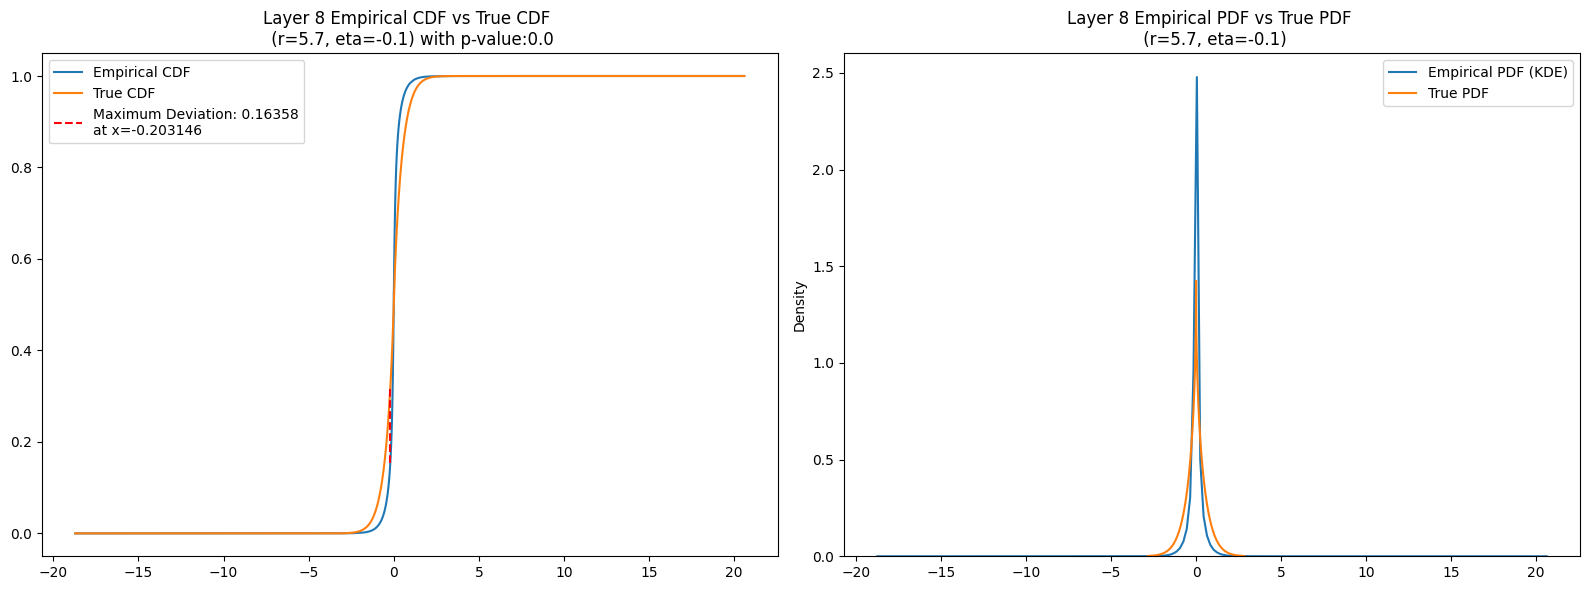

In [13]:
for layer in np.arange(2, 9):
    layer_info = large_grid_df.loc[layer]
    visualize_cdf_pdf(obs_x_dict[layer], params = (layer_info['best_r_cd'], layer_info['best_eta_cd']), all_cdfs = combine_pickles(f'layer{layer}_10000'), layer = layer)

## Comparing with Gaussian and Laplace

No Tail
No Tail


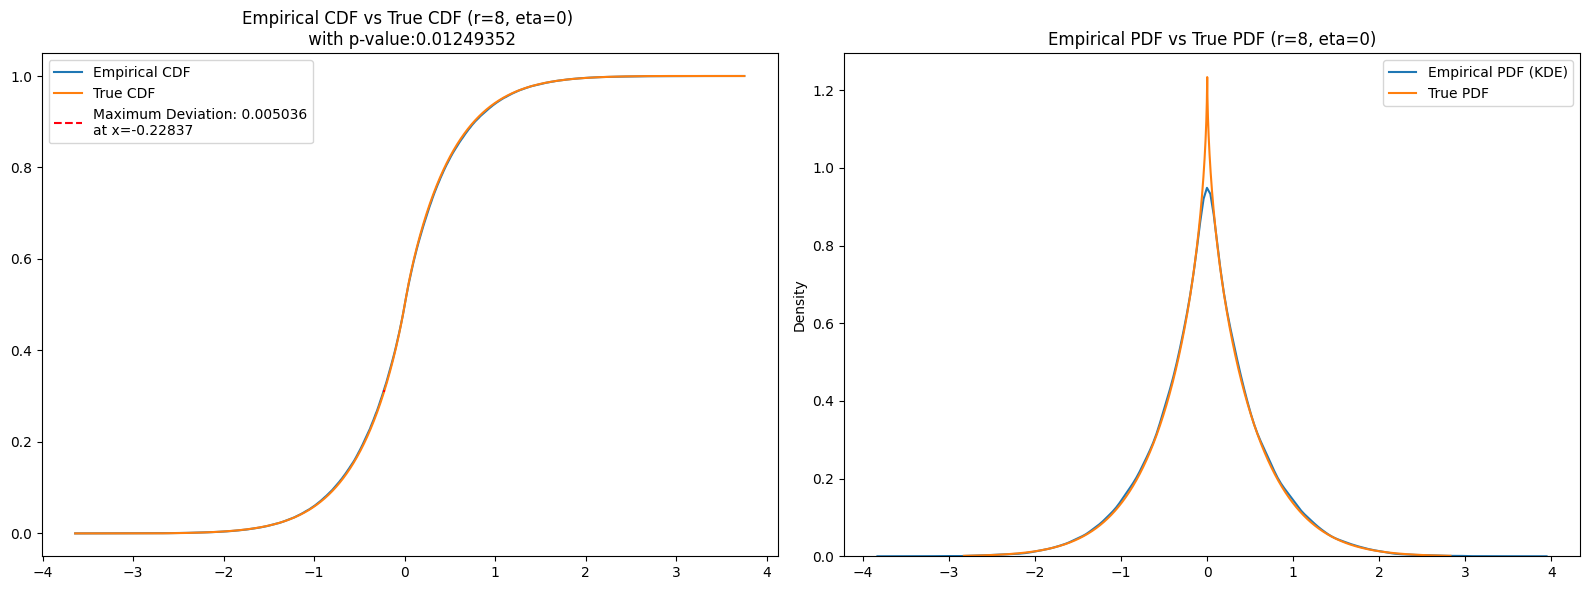

(0.005036029177662882, -0.2283702892391437)

In [ ]:
visualize_cdf_pdf(sorted(sample_prior(20, 0, 100000)), r = 8, eta = 0, all_cdfs = all_cdfs)

No Tail
No Tail


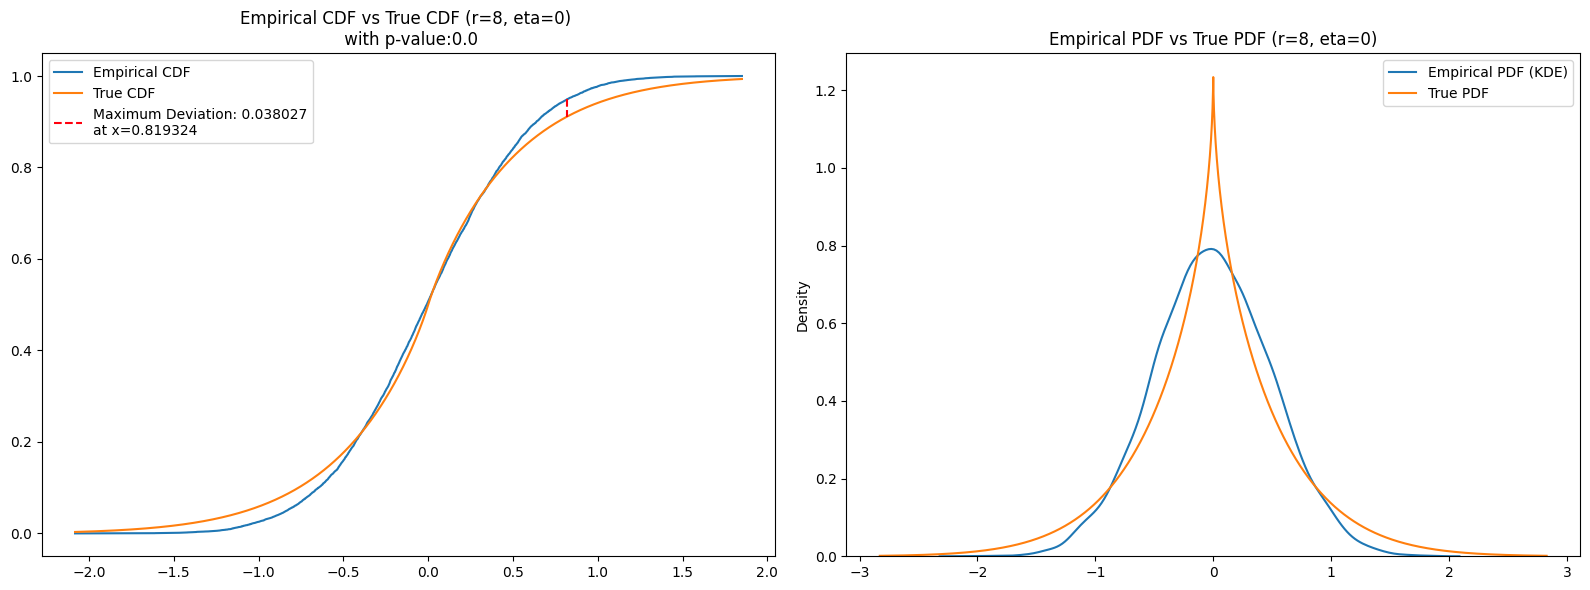

(0.03802735954918468, 0.8193244944020612)

In [ ]:
visualize_cdf_pdf(sorted(scipy.stats.norm(scale=0.5).rvs(size=10000)), r = 8, eta = 0, all_cdfs = all_cdfs)

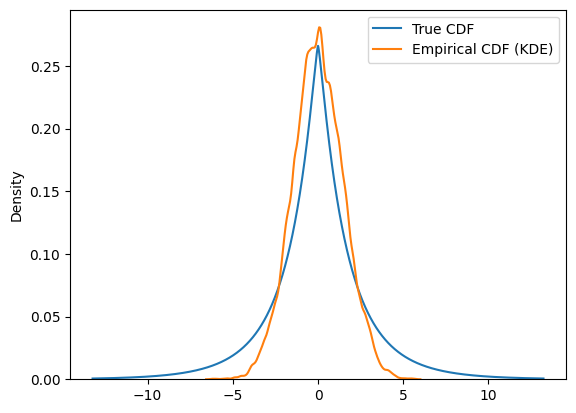

In [ ]:
# Note that this is with KDEs, subjective element with bandwidth parameter, but I think conveys the idea well
xs, pdf = compute_prior_pdf(1, 1)
cdf = all_cdfs[(1,1)]
plt.plot(xs, pdf, label = 'True CDF')
sns.kdeplot(sorted(scipy.stats.norm(scale=1.5).rvs(size=10000)), label = 'Empirical CDF (KDE)', bw_adjust = 0.5)

plt.legend()

In [14]:
def generate_func(sample, distro, *args):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale = var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale = var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'gengamma_r':
        eta = args[0]
        def r_func(r):
            print(r, eta)
            cdf = compute_prior_cdf(r, eta, 10000)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'gengamma_eta':
        r = args[0]
        def eta_func(eta):
            print(r, eta)
            cdf = compute_prior_cdf(r, eta, 10000)
            return compute_ksstat(sample, cdf) 
        return eta_func
    print("Please enter a valid argument for `distro` : 'gaussian', 'laplace', 'gengamma_r', 'gengamma_eta'")

In [194]:
scipy.optimize.minimize_scalar(generate_func(obs_x_dict[5], 'gengamma_r', 1.62), method = 'bounded', bounds = (0.8, 1))

0.876393202250021 1.62
No Tail
0.923606797749979 1.62
No Tail
0.847213595499958 1.62
No Tail
0.8983227664878977 1.62
No Tail
0.8992357684081762 1.62
No Tail
0.904590053310079 1.62
No Tail
0.9012809232552527 1.62
No Tail
0.9025448984630026 1.62
No Tail
0.9010084046094493 1.62
No Tail
0.9014936935293212 1.62
No Tail
0.9018952180848459 1.62
No Tail
0.9021433739074778 1.62
No Tail
0.9018144232714843 1.62
No Tail
0.901990005174585 1.62
No Tail
0.9020485868177386 1.62
No Tail
0.9019671108490858 1.62
No Tail
0.9020123813711529 1.62
No Tail
0.9020262106211707 1.62
No Tail
0.902003834424603 1.62
No Tail
0.9020176636746208 1.62
No Tail
0.9020090346588139 1.62
No Tail


 message: Solution found.
 success: True
  status: 0
     fun: 0.003126479899061674
       x: 0.9020123813711529
     nit: 21
    nfev: 21

In [15]:
for layer in np.arange(2, 9):
    norm_result = scipy.optimize.minimize_scalar(generate_func(obs_x_dict[layer], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(obs_x_dict[layer], 'laplace'), method = 'bounded', bounds = (0, 50))
    large_grid_df.loc[layer, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    large_grid_df.loc[layer, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    large_grid_df.loc[layer, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    large_grid_df.loc[layer, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)

large_grid_df.to_csv(f'panoptic/CSVs/final_grid_df.csv')
large_grid_df

In [20]:
large_grid_df

,num_samples,initial_param,kstest_stat,best_param_eta_0,kstest_stat_eta_0,best_r_cd,best_eta_cd,kstest_stat_cd,n_0.05,param_gaussian,kstest_stat_gaussian,param_laplace,kstest_stat_laplace
layer,,,,,,,,,,,,,
2,3180,"(0.6, 3.2)",0.038340,"(0.4, 0)",0.102709,0.602,3.20,0.036033,1341,27.782300,0.019503,25.439100,0.036392
3,12720,"(0.7, 3.5)",0.020230,"(0.4, 0)",0.106739,0.705,3.60,0.019860,4770,16.031400,0.010128,14.012900,0.022665
4,50880,"(0.8, 3.0)",0.011666,"(0.5, 0)",0.061078,0.803,3.00,0.010449,16098,8.001070,0.020474,7.104980,0.014498
5,203520,"(0.9, 1.6)",0.003225,"(0.6, 0)",0.040301,0.904,1.60,0.004425,96592,3.590120,0.030175,3.138820,0.002343
6,814080,"(1.1, 0.5)",0.006844,"(0.9, 0)",0.014370,1.030,0.33,0.003707,128142,1.426170,0.042370,1.246790,0.014477
7,3256320,"(4.6, 0.0)",0.024895,"(4.6, 0)",0.024895,4.630,0.00,0.024879,3016,0.539642,0.052925,0.472750,0.025277
8,13025280,"(5.7, 0.0)",0.171259,"(5.7, 0)",0.171259,5.700,-0.10,0.163580,67,0.196018,0.056353,0.172564,0.029150


In [19]:
large_grid_df.filter(regex='kstest_stat.*')

,kstest_stat,kstest_stat_eta_0,kstest_stat_cd,kstest_stat_gaussian,kstest_stat_laplace
layer,,,,,
2,0.038340,0.102709,0.036033,0.019503,0.036392
3,0.020230,0.106739,0.019860,0.010128,0.022665
4,0.011666,0.061078,0.010449,0.020474,0.014498
5,0.003225,0.040301,0.004425,0.030175,0.002343
6,0.006844,0.014370,0.003707,0.042370,0.014477
7,0.024895,0.024895,0.024879,0.052925,0.025277
8,0.171259,0.171259,0.163580,0.056353,0.029150


In [ ]:
%%time
# Creates validation dataframes 
# For now, it caps out at 6. For layer 7 and up it just defaults to 2.9, 0

# for layer in range(6, 8):
#     obs_x = create_obs_x(data_dict, layer)
#     df = make_layer_df(obs_x, all_cdfs_df)
#     total_samples = obs_x.size
#     all_num_samples = np.sort(np.append(5*10**np.arange(3.0, np.floor(np.log10(total_samples))), 10**np.arange(3.0, np.ceil(np.log10(total_samples)))))
#     print(list(all_num_samples))
#     np.random.seed(42)
#     x = obs_x[np.random.permutation(total_samples)]
#     val_df = pd.concat([val_df_fixed_num(x, n, all_cdfs_df) for n in all_num_samples])
#     val_df.to_csv(f'panoptic/CSVs/val_df{layer}_{cdfs_name}.csv')
#     val_df.value_counts(['r', 'eta'])

In [ ]:
val_df = pd.read_csv(f'panoptic/CSVs/val_df{4}.csv', index_col='Unnamed: 0')
print(val_df.value_counts(['r', 'eta'])[:10])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure with two subplots

for layer in np.arange(layer, layer+1):
    #obs_x = obs_x_dict[layer]
    #df = df_dict[layer]
    total_samples = obs_x.size
    x = obs_x[np.random.permutation(total_samples)]
    val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}_{cdfs_name}.csv', index_col='Unnamed: 0')

    # Scatter plot
    sns.scatterplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis=1), x='r', y='eta', palette='bright', hue='num_samples', alpha=0.4, ax=ax1)
    r, eta = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
    ax1.scatter(x=r, y=eta, marker="*", label='all_data', s=60, color='xkcd:shamrock green', alpha=0.7)
    ax1.set_title(f'KS-Test Statistic minimizing parameters for subsets of layer {layer} data')
    print(r, eta)
    ax1.legend()

    # KDE plot
    sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis=1), x='r', y='eta', palette='bright', hue='num_samples', alpha=0.4, ax=ax2)

plt.tight_layout()
plt.show()

In [ ]:
np.random.seed(42)

# TODO: Put plots side by side
for layer in np.arange(layer, layer+1):
    obs_x = obs_x_dict[layer]
    df = df_dict[layer]
    total_samples = obs_x.size
    x = obs_x[np.random.permutation(total_samples)]
    val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}.csv', index_col='Unnamed: 0')
    sns.scatterplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
    r, eta, = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
    plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.7)
    plt.title(f'KS-Test Statistic minimizing parameters for subsets of layer {layer} data')
    print(r, eta)
    plt.legend()
    
    sns.kdeplot(val_df.drop(['kstest_stat', 'kstest_pval'], axis = 1), x = 'r', y = 'eta', palette = 'bright', hue = 'num_samples', alpha = 0.4)
    

In [ ]:
layer = 6
val_df = pd.read_csv(f'panoptic/CSVs/val_df{layer}.csv', index_col='Unnamed: 0')
mask = val_df['num_samples'] == 100
sns.kdeplot(val_df.drop(['kstest_pval'], axis = 1)[mask], x = 'r', y = 'eta', fill=True)
r, eta, = best_params_df.loc[layer]['r'], best_params_df.loc[layer]['eta']
plt.scatter(x = r, y = eta, marker="*", label = 'all_data', s = 60, color = 'xkcd:shamrock green', alpha = 0.7)
plt.title('Validation')